In [1]:
pip install repo2text

In [2]:
!repo2text .py https://github.com/danielegrattarola/GNCA

Cloning repository from https://github.com/danielegrattarola/GNCA...
Repository has been written to GNCA_py.txt


In [ ]:
# @title Horizon 3: The Financial Physics Engine
# Adapted from Grattarola et al. (modules/ca.py)

import torch
import numpy as np

class FinancialContagionCA:
    """
    Simulates Systemic Risk propagation on a financial network.
    Rule: A bank fails (1) if the weighted sum of failing partners exceeds its capital buffer.
    """
    def __init__(self, adj_matrix, capital_buffer=0.4):
        self.adj = adj_matrix # The Debt/Correlation Network
        self.buffer = capital_buffer

    def step(self, state):
        # state: Binary vector [N, 1] (0=Solvent, 1=Insolvent)

        # 1. Calculate Exposure (The "Density" in Grattarola's code)
        # "densities = self.graph.a @ state"
        exposure = torch.matmul(self.adj, state)

        # 2. The Default Rule (The "Transition")
        # If exposure > buffer, the bank defaults.
        # This is a Threshold Rule (Class 2 -> Class 3 transition).
        new_state = (exposure > self.buffer).float()

        return new_state

In [1]:
# @title The Environment
# Horizon 3: The Hive Mind - Initial Replication
# Based on Grattarola et al. (2021) "Learning Graph Cellular Automata"
# Adapted for Systemic Risk Modeling by Algoplexity

!pip install torch torch_geometric networkx matplotlib seaborn

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import MessagePassing
from torch_geometric.utils import from_networkx
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Set seed for reproducibility (The "Ground Truth" must be stable)
torch.manual_seed(42)
np.random.seed(42)

print("Algoplexity Hive Mind Environment: READY")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.7/63.7 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 40.1 MB/s eta 0:00:00
Algoplexity Hive Mind Environment: READY


In [2]:
# @title The Physics Engine (The Ground Truth)
# The Ground Truth Generator
class FinancialContagionCA:
    """
    The Ground Truth Generator.
    Simulates a banking network where insolvency spreads via debt links.

    Rule: A node turns '1' (Insolvent) if the weighted sum of its '1' neighbors
    exceeds its Capital Buffer (Threshold).
    """
    def __init__(self, num_nodes=100, edge_prob=0.1, capital_buffer=0.3):
        self.num_nodes = num_nodes
        self.buffer = capital_buffer

        # 1. Generate the Topology (The Interbank Network)
        # We use Erdos-Renyi for now (Random Graph)
        self.G = nx.erdos_renyi_graph(n=num_nodes, p=edge_prob)

        # Convert to PyTorch Geometric Data format
        self.data = from_networkx(self.G)

        # Create Normalized Adjacency Matrix for efficient calculation
        # A_norm = D^-1 * A (Row-normalized: percentage of exposure)
        adj_numpy = nx.to_numpy_array(self.G)
        deg = adj_numpy.sum(axis=1, keepdims=True)
        deg[deg == 0] = 1 # Avoid div by zero
        self.adj_matrix = torch.tensor(adj_numpy / deg, dtype=torch.float32)

    def step(self, current_state):
        """
        Evolves the network one step forward in time (t -> t+1).
        state: [N, 1] Tensor (0 = Solvent, 1 = Default)
        """
        # 1. Calculate Counterparty Exposure
        # How many of my neighbors have defaulted?
        exposure = torch.matmul(self.adj_matrix, current_state)

        # 2. The Default Rule (The Non-Linear Transition)
        # If Exposure > Buffer, I default.
        # We add 'current_state' so that dead banks stay dead (Absorbing State)
        new_state = (exposure > self.buffer).float() + current_state
        new_state = torch.clamp(new_state, 0, 1) # Cap at 1

        return new_state

# --- Test the Engine ---
# Create a network
sim = FinancialContagionCA(num_nodes=50, edge_prob=0.15, capital_buffer=0.25)

# Patient Zero: Infect 3 random banks
state_t = torch.zeros(sim.num_nodes, 1)
state_t[0:3] = 1.0

# Evolve
state_t1 = sim.step(state_t)
state_t2 = sim.step(state_t1)

print(f"T=0 Defaults: {state_t.sum().item()}")
print(f"T=1 Defaults: {state_t1.sum().item()}")
print(f"T=2 Defaults: {state_t2.sum().item()}")

T=0 Defaults: 3.0
T=1 Defaults: 4.0
T=2 Defaults: 5.0


In [3]:
# @title The Neural Engine (The GNCA)

# The Learner
class SystemicGNCA(MessagePassing):
    """
    The Learner.
    Replicates Grattarola's Eq 4: h' = MLP( h || sum(ReLU(W * h_j)) )

    Goal: Learn to predict t+1 given t, solely from local message passing.
    """
    def __init__(self, hidden_dim=32):
        super(SystemicGNCA, self).__init__(aggr='add') # Sum aggregation

        # 1. Pre-processing (Encoder)
        # Maps binary state (0/1) to high-dimensional thought vector
        self.encoder = nn.Sequential(
            nn.Linear(1, hidden_dim),
            nn.ReLU()
        )

        # 2. Message Transformation (The "W")
        self.msg_transform = nn.Linear(hidden_dim, hidden_dim)

        # 3. Update Rule (The "Program")
        # Takes Self + Neighbors -> Next State
        self.update_mlp = nn.Sequential(
            nn.Linear(hidden_dim * 2, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1) # Output logits for solvency
        )

    def forward(self, x, edge_index):
        # x: [N, 1]

        # Encode
        h = self.encoder(x)

        # Propagate (Message Passing)
        # This calls message() -> aggregate() -> update()
        neighbor_signal = self.propagate(edge_index, x=h)

        # Update
        combined = torch.cat([h, neighbor_signal], dim=1)
        out = self.update_mlp(combined)
        return out

    def message(self, x_j):
        # x_j: Features of neighbors
        return F.relu(self.msg_transform(x_j))

# Instantiate
model = SystemicGNCA(hidden_dim=32)
print(model)

SystemicGNCA()


--- Training the Hive Mind ---
Epoch 0: Loss = 0.135716
Epoch 50: Loss = 0.000013
Epoch 100: Loss = 0.000001
Epoch 150: Loss = 0.000000
Epoch 200: Loss = 0.000000
Epoch 250: Loss = 0.000361
Epoch 300: Loss = 0.000006
Epoch 350: Loss = 0.000000
Epoch 400: Loss = 0.000000
Epoch 450: Loss = 0.000000


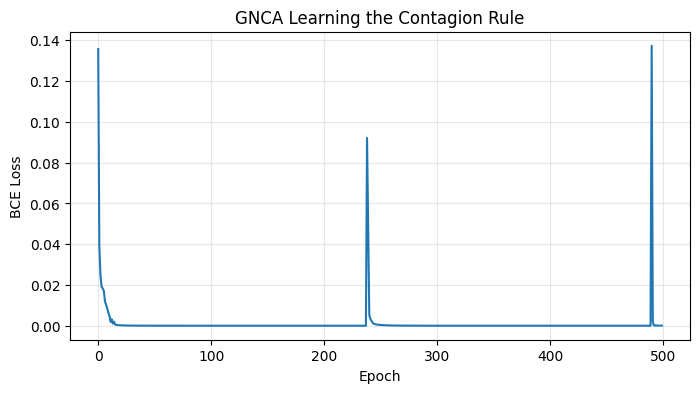

In [4]:
# @title The Experiment
# 1. Generate Training Data
# We create 100 different "Crisis Scenarios"
dataset = []
for _ in range(100):
    # Random initial state (scattered defaults)
    x = torch.randint(0, 2, (sim.num_nodes, 1)).float()
    y = sim.step(x) # The Ground Truth next step
    dataset.append((x, y))

# 2. Setup Training
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = nn.BCEWithLogitsLoss() # Binary Cross Entropy

# 3. Train
print("--- Training the Hive Mind ---")
edge_index = sim.data.edge_index # Graph topology is fixed for this exp

loss_history = []

for epoch in range(500):
    epoch_loss = 0
    for x_batch, y_batch in dataset:
        optimizer.zero_grad()

        # Forward pass
        pred_logits = model(x_batch, edge_index)

        # Loss
        loss = criterion(pred_logits, y_batch)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    loss_history.append(epoch_loss / len(dataset))

    if epoch % 50 == 0:
        print(f"Epoch {epoch}: Loss = {loss_history[-1]:.6f}")

# Plot Learning Curve
plt.figure(figsize=(8,4))
plt.plot(loss_history)
plt.title("GNCA Learning the Contagion Rule")
plt.xlabel("Epoch")
plt.ylabel("BCE Loss")
plt.grid(True, alpha=0.3)
plt.show()

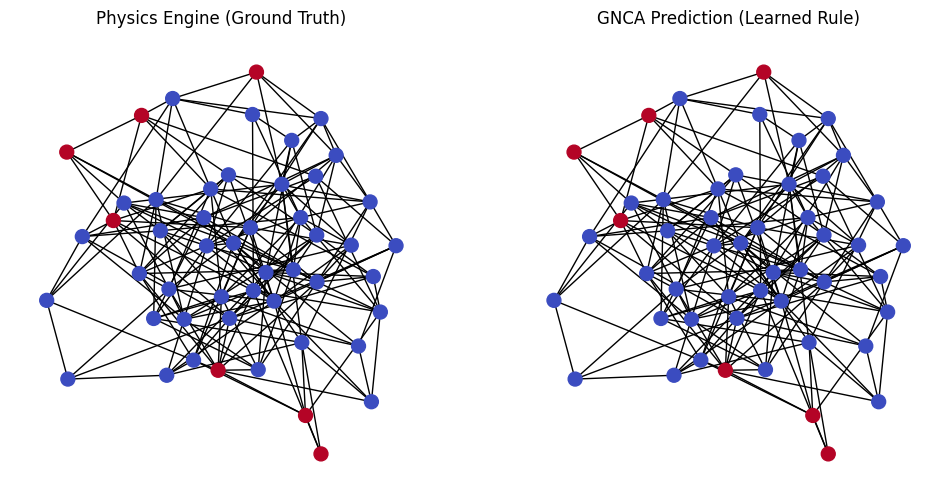

Replication Accuracy: 100.00%


In [5]:
# @title The Money Shot
# Run a Test Simulation
test_x = torch.zeros(sim.num_nodes, 1)
test_x[10:15] = 1.0 # Inject a cluster of failures

# Ground Truth Next Step
true_next = sim.step(test_x)

# GNCA Predicted Next Step
with torch.no_grad():
    pred_logits = model(test_x, edge_index)
    pred_probs = torch.sigmoid(pred_logits)
    pred_next = (pred_probs > 0.5).float() # Threshold at 0.5

# Visual Comparison
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

pos = nx.spring_layout(sim.G, seed=42)

# True State
nx.draw(sim.G, pos, ax=ax[0],
        node_color=true_next.numpy().flatten(),
        cmap='coolwarm', node_size=100, with_labels=False)
ax[0].set_title("Physics Engine (Ground Truth)")

# Predicted State
nx.draw(sim.G, pos, ax=ax[1],
        node_color=pred_next.numpy().flatten(),
        cmap='coolwarm', node_size=100, with_labels=False)
ax[1].set_title("GNCA Prediction (Learned Rule)")

plt.show()

# Accuracy Check
acc = (true_next == pred_next).float().mean()
print(f"Replication Accuracy: {acc.item() * 100:.2f}%")